## LSE 455 Seminar 09 : Reinforcement Learning - Dyna: Integrated Planning, Acting, and Learning

The content of this notebook accompanies Chapter 8 in the Sutton & Barto book.



<img src="graphs/planning_chart.png" width=700>


<img src="graphs/tabular_dyna_q.png" width=700>


In [1]:
#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm #progressbar
from copy import deepcopy

In the following we implement following Maze

<img src="graphs/maze.png" width=400>

The aim is to find a shortest path from S to G. Movements are allowed left, right, top and down but not on the greyed out obstacles. 

Standard Random-sample one step tabular Q-planning methods suffer from only learning approximating the Q-value of tiles of distance $k$ in $k$ many iterations as depicted below.

<img src="graphs/planning_vs_without_planning.png">

The Dyna-Q Method on the right on the other hand, which _revisits_ previously observed states ("Planning") is able to offline at the end of an episode to update the Q-values accordingly.


In [2]:
class Maze:
    def __init__(self):
        # maze width
        self.WORLD_WIDTH = 9

        # maze height
        self.WORLD_HEIGHT = 6

        # all possible actions
        self.ACTION_UP = 0
        self.ACTION_DOWN = 1
        self.ACTION_LEFT = 2
        self.ACTION_RIGHT = 3
        self.actions = [self.ACTION_UP, self.ACTION_DOWN, self.ACTION_LEFT, self.ACTION_RIGHT]

        # start state
        self.START_STATE = [2, 0]

        # goal state
        self.GOAL_STATES = [[0, 8]]

        # all obstacles
        self.obstacles = [[1, 2], [2, 2], [3, 2], [0, 7], [1, 7], [2, 7], [4, 5]]
        
        # the size of q value
        self.q_size = (self.WORLD_HEIGHT, self.WORLD_WIDTH, len(self.actions))

        # max steps
        self.max_steps = float('inf')

    # take @action in @state
    # @return: [new state, reward]
    def step(self, state, action):
        x, y = state
        if action == self.ACTION_UP:
            x = max(x - 1, 0)
        elif action == self.ACTION_DOWN:
            x = min(x + 1, self.WORLD_HEIGHT - 1)
        elif action == self.ACTION_LEFT:
            y = max(y - 1, 0)
        elif action == self.ACTION_RIGHT:
            y = min(y + 1, self.WORLD_WIDTH - 1)
        if [x, y] in self.obstacles:
            x, y = state
        if [x, y] in self.GOAL_STATES:
            reward = 1.0
        else:
            reward = 0.0
        return [x, y], reward

# a wrapper class for parameters of dyna algorithms
class DynaParams:
    def __init__(self):
        # discount
        self.gamma = 0.95

        # probability for exploration
        self.epsilon = 0.1

        # step size
        self.alpha = 0.1

        # weight for elapsed time
        self.time_weight = 0

        # n-step planning
        self.planning_steps = 5

        # average over several independent runs
        self.runs = 10

        # threshold for priority queue
        self.theta = 0


# choose an action based on epsilon-greedy algorithm
def choose_action(state, q_value, maze, dyna_params):
    if np.random.binomial(1, dyna_params.epsilon) == 1:
        return np.random.choice(maze.actions)
    else:
        values = q_value[state[0], state[1], :]
        return np.random.choice([action for action, value in enumerate(values) if value == np.max(values)])

# Table lookup model for planning in Dyna-Q
class TrivialModel:
    # @rand: an instance of np.random.RandomState for sampling
    def __init__(self, rand=np.random):
        self.model = dict()
        self.rand = rand

    # feed the model with previous experience
    def feed(self, state, action, next_state, reward):
        state = deepcopy(state)
        next_state = deepcopy(next_state)
        if tuple(state) not in self.model.keys(): # keys of dictionary shall be immutable, use tuble instead of list
            self.model[tuple(state)] = dict()
        self.model[tuple(state)][action] = [list(next_state), reward] 
    # In the last line, instead of appending the next_state-reward pair into a list, we replace it with the most
    # recent observations. This is reasonable because under the current environment, the state transition and reward
    # functions are deterministic. For each state-action pair, the associated next_state-reward pair can only take one
    # value

    # randomly sample from previous experience
    def sample(self):
        state_index = self.rand.choice(range(len(self.model.keys())))
        state = list(self.model)[state_index]
        action_index = self.rand.choice(range(len(self.model[state].keys())))
        action = list(self.model[state])[action_index]
        next_state, reward = self.model[state][action] 
        # For each state-action pair, there is only one unique next_state-reward pair
        state = deepcopy(state) ## list is mutable, use deepcopy instead
        next_state = deepcopy(next_state)
        return list(state), action, list(next_state), reward

In [3]:
# play for an episode for Dyna-Q algorithm
# @q_value: state action pair values, will be updated
# @model: model instance for planning
# @maze: a maze instance containing all information about the environment
# @dyna_params: several params for the algorithm
def dyna_q(q_value, model, maze, dyna_params):
    state = maze.START_STATE
    steps = 0
    while state not in maze.GOAL_STATES:
        # track the steps
        steps += 1

        # get action
        action = choose_action(state, q_value, maze, dyna_params)

        # take action
        next_state, reward = maze.step(state, action)

        # Q-Learning update
        q_value[state[0], state[1], action] += \
            dyna_params.alpha * (reward + dyna_params.gamma * np.max(q_value[next_state[0], next_state[1], :]) -
                                 q_value[state[0], state[1], action])

        # feed the model with experience
        model.feed(state, action, next_state, reward)

        # sample experience from the model
        for t in range(0, dyna_params.planning_steps):
            state_, action_, next_state_, reward_ = model.sample()
            q_value[state_[0], state_[1], action_] += \
                dyna_params.alpha * (reward_ + dyna_params.gamma * np.max(q_value[next_state_[0], next_state_[1], :]) -
                                     q_value[state_[0], state_[1], action_])

        state = next_state

        # check whether it has exceeded the step limit
        if steps > maze.max_steps:
            break

    return steps


100%|███████████████████████████████████████████| 10/10 [00:31<00:00,  3.18s/it]


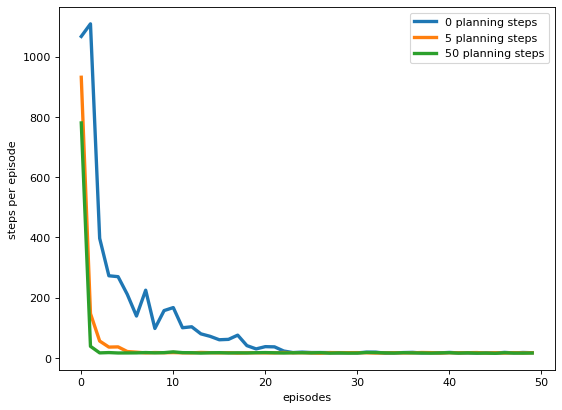

In [4]:
# set up an instance for DynaMaze
dyna_maze = Maze()
dyna_params = DynaParams()

runs = 10
episodes = 50
planning_steps = [0, 5, 50]
steps = np.zeros((len(planning_steps), episodes))

for run in tqdm(range(runs)):
    for i, planning_step in enumerate(planning_steps):
        dyna_params.planning_steps = planning_step
        q_value = np.zeros(dyna_maze.q_size)

        # generate an instance of Dyna-Q model
        model = TrivialModel()
        for ep in range(episodes):
            # print('run:', run, 'planning step:', planning_step, 'episode:', ep)
            steps[i, ep] += dyna_q(q_value, model, dyna_maze, dyna_params)

# averaging over runs
steps /= runs

plt.figure(figsize=(8, 6), dpi=80)


for i in range(len(planning_steps)):
    plt.plot(steps[i, :], label='%d planning steps' % (planning_steps[i]), linewidth=3)

plt.xlabel('episodes')
plt.ylabel('steps per episode')
plt.legend()
plt.show()